In [2]:
from itertools import product
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
data = pd.read_csv("data/melb_data.csv")
data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:>

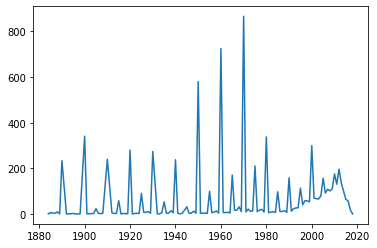

In [4]:
minyr = 1880
year = data["YearBuilt"].value_counts().sort_index()
year = year[year.index > minyr]
year.plot()

Periodic spikes on the first year of each decade, *e.g.*, 1951, 1961, 1971. Smaller frequency every 5 years.

In [5]:
diff = year - year.shift(1)
diff.sort_values().head(20)

1971.0   -856.0
1961.0   -718.0
1951.0   -576.0
1901.0   -340.0
1981.0   -332.0
1921.0   -279.0
1932.0   -273.0
1941.0   -234.0
1912.0   -234.0
1892.0   -233.0
2001.0   -230.0
1976.0   -200.0
1966.0   -154.0
1991.0   -146.0
1956.0    -94.0
1986.0    -87.0
1926.0    -83.0
1996.0    -73.0
2006.0    -65.0
2013.0    -61.0
Name: YearBuilt, dtype: float64

In [6]:
data.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [13]:
code, suburbs = pd.factorize(data.Suburb)
data["SuburbFac"] = code
data["Datedt"] = pd.to_datetime(data["Date"])

In [14]:
cols = [""]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,SuburbFac,Datedt
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,0,2016-03-12
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,0,2016-04-02
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,0,2017-04-03
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,0,2017-04-03
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,0,2016-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,248,2017-08-26
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0,104,2017-08-26
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0,104,2017-08-26
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0,104,2017-08-26
